# Importing all necessary packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
from fitter import Fitter
#import attr
from collections import defaultdict, OrderedDict
import pylogit as pl
from functools import reduce

# Distribution Fitting Class Definition

In [89]:
class FitDistribution(object):
    """Fit and simulate data to known distributions.
    
    Input:
    ------
    - data: array-like or dataframe.
    - dists: list.
        This parameter contains a list of distributions to be explored.
        When None, every available distribution on scipy is explored.
    - bins: int. 
        Numbers of bins to be used for the cumulative histogram. This has
        an impact on the quality of the fit.
    - timeout: int. 
        Maximum time for a given distribution. If timeout is reached, 
        the distribution is skipped.
        """
    def __init__(self, data, dists=None, timeout=30, verbose=False, bins=100):
        self.data = data
        #self.var_types = var_types
        self.dists = dists
        self.timeout = timeout
        self.verbose = verbose
        self.bins = bins
        self.ArrayDistDict = defaultdict()
        self.params_dict = defaultdict(dict)

    def FindArrayDist(self, cat_var):
        """Function to extract the best distribution for a specified array.
        Uses the fit method from the Fitter module in the fitter library
        Inputs:
        -------
        - cat_var: boolean
            Boolean to signify whether the variable to be simulated
            is discrete/categorical or continuous.
        
        Outputs:
        -------
        By default, the function returns a dictionary with best distribution name
        and parameters associated with it. If a number of distributions
        was specified, the function returns a pandas DataFrame with
        the N best distributions, along with a plot showing all of them."""
        self.ArrayDistDict = dict()
        if  cat_var == True:
            self.ArrayDistDict['distribution'] = 'categorical'
            np_array_range = np.arange(self.data.max()+1)
            array_bincount = np.bincount(self.data)
            probs = array_bincount / len(self.data)
            
            self.ArrayDistDict['parameters'] = [np_array_range,
                                                probs]            
        else:
            fitter_object = Fitter(data=self.data,
                                   distributions=self.dists,
                                   timeout=self.timeout)
            fitter_object.fit()
            BestDict = fitter_object.get_best()
            self.ArrayDistDict['distribution'] = list(BestDict.items())[0][0]
            self.ArrayDistDict['parameters'] = list(BestDict.items())[0][1]
        return self.ArrayDistDict
    
    def SimArray(self, size=100):
        """Function to simulate data for an array based on the best fitted
        distribution.
        Input:
        -----
        - size : int
                size of the array to be simulated.
        Outputs:
        -------
        Simulated array based on the best fit distribution."""
        if self.ArrayDistDict['distribution'] == 'categorical':
            Sim_Array = np.random.choice(a=self.ArrayDistDict['parameters'][0],
                                         p=self.ArrayDistDict['parameters'][1],
                                         size=size)
        else:
            dist = getattr(scipy.stats, self.ArrayDistDict['distribution'])
            Sim_Array = dist.rvs(*self.ArrayDistDict['parameters'], size=size)
        return Sim_Array
    
    def FindDfDist(self, var_types):
        """Function to extract the best distribution from a specified dataframe.
        Uses the function find_dist, which in turn uses the fit method from the
        Fitter module in the fitter library
        Inputs:
        -------
        - var_types: dictionary
            Dictionary with keys as column names for dataset variables, the value
            of each key is a string showing whether the variable is discrete/cat
            or continuous.

        Outputs:
        -------
        *FOR NOW*, the function returns a dictionary showing the best distribution
        name for each array in the dataframe and parameters associated with it.
        """
        
        
        for column in list(self.data.columns):
            
            if  var_types[column] == 'categorical':
                if len(self.data[column].unique()) == 1:
                    self.params_dict[column]['distribution'] = 'constant'
                    self.params_dict[column]['parameters'] = self.data[column].unique()
                else:
                    self.params_dict[column]['distribution'] = 'categorical'
                    np_array_range = np.arange(self.data[column].max()+1)
                    array_bincount = np.bincount(self.data[column])
                    probs = array_bincount / len(self.data[column])
                    self.params_dict[column]['parameters'] = [np_array_range,
                                                              probs]            
            else:
                if len(self.data[column].unique()) == 1:
                    self.params_dict[column]['distribution'] = 'constant'
                    self.params_dict[column]['parameters'] = self.data[column].unique()
                else:
                    fitter_object = Fitter(data=self.data[column],
                                           distributions=self.dists,
                                           timeout=self.timeout)
                    fitter_object.fit()
                    BestDict = fitter_object.get_best()
                    self.params_dict[column]['distribution'] = list(BestDict.items())[0][0]
                    self.params_dict[column]['parameters'] = list(BestDict.items())[0][1]
        return self.params_dict

    def SimDf(self, size=1000):
        """Funtion to simulate data of size N based on specified
        distribution/parameters found by the fitter package.
        Inputs:
        -------
        data: dataframe from which columns are to be taken
        dist_params: the distribution parameters from find_dist_df
        Outputs:
        -------
        DataFrame object with simulated data based on specified distributions
        """
        Sim_Df = pd.DataFrame(columns=list(self.params_dict.keys()))
        Sim_Df = Sim_Df.fillna(0)
        for column in list(self.params_dict.keys()):
            if self.params_dict[column]['distribution'] == 'categorical':
                data_sim = np.random.choice(a=self.params_dict[column]['parameters'][0],
                                            p=self.params_dict[column]['parameters'][1],
                                            size=size)
                Sim_Df[column] = data_sim
            elif self.params_dict[column]['distribution'] == 'constant':
                data_sim = self.params_dict[column]['parameters'][0]
                Sim_Df[column] = data_sim
            else:
                dist = getattr(scipy.stats, self.params_dict[column]['distribution'])
                data_sim = dist.rvs(*self.params_dict[column]['parameters'], size=size)
                Sim_Df[column] = data_sim
        return Sim_Df

# Functions to calculate probabilities for each alternative **(to be replaced by functions from the choice_tools module in pylogit)**

In [3]:
def add_intercept_to_df(df_long, specification_dict):
    
    if ("intercept" in specification_dict 
        and "intercept" not in df_long.columns):
        df_long["intercept"] = 1
    
    return None

def create_design_matrix(df_long, specification_dict,
                         names_dict, alternative_id_col):
    
    add_intercept_to_df(df_long,specification_dict)
    
    columns = []
    for col in specification_dict:
        for group in specification_dict[col]:
            if type(group) == list:
                columns.append(df_long[alternative_id_col].isin(group)
                               *df_long[col])
            else:
                columns.append((df_long[alternative_id_col]==group)
                               *df_long[col])
    
    design_matrix = np.stack(columns,axis = 1)
    
    var_names = []
    for variable in names_dict:
        for name in names_dict[variable]:
            var_names.append(name)
    
    return design_matrix, var_names


def calculate_utilities(betas, design_matrix):
    
    limit_max = 700
    limit_min = -700 
    
    utility = design_matrix.dot(betas)
    utility[utility>limit_max] = limit_max
    utility[utility<limit_min] = limit_min
    
    utilities = np.exp(utility)
    
    return utilities


def create_mapping_matrix(df_long, observation_id_col):
    row_to_col_matrix = pd.get_dummies(df_long[observation_id_col]).values
#     row_to_col_matrix = (df_long[observation_id_col].values[:,None] == 
#                          np.sort(df_long[observation_id_col].unique())[None,:]).astype(int) 
    sparse_row_to_col_matrix = sparse.csr_matrix(row_to_col_matrix)
    
    mapping_matrix = sparse_row_to_col_matrix.dot(sparse_row_to_col_matrix.T)
    
    return mapping_matrix


def calculate_probabilities(betas,design_matrix, mapping_matrix):
    
    utilities = calculate_utilities(betas, design_matrix)
    denominator = mapping_matrix.dot(utilities)
    probabilities = utilities/denominator
    probabilities[probabilities==0] = 1e-300
    
    
    return probabilities

# Function to simulate choices based on long data format (This will be potentially extended to simulate choices directly from wide data)

In [4]:
def SimulateChoices(data, alt_id_col, obs_id_col, number_alts, spec_dic, names_dic, init_betas):

# This commented out block is to extend the capabilities of the function from simulating choices
# only based on long data to wide data. The logic is built out completely, all we need is to 
# refactor it and adjust the parameters in the function definition.
#     choice_var = 'choice'
#     custom_alt_id = "alternative_id"
#     obs_id_column = "custom_id"

#     # Adding a Choice Variable Column
#     data[choice_var] = np.random.randint(1, high=number_alts+1, size=data.shape[0])
#     availability_variables = dict()

#     # Adding availability variables and specifying alternative availability numbers
#     for alt in np.arange(1, number_alts+1, 1):
#         data['AV_' + str(alt)] = 1
#         availability_variables[alt] = 'AV_' + str(alt)

#     # Specifying the Individual Variables
#     ind_variables = ind_variables

#     alt_varying_variables = alt_var_vars
#     # Specifying the column heading for the alternative id column in the
#     # long format dataset
#     custom_alt_id = "alternative_id"
#     obs_id_column = "custom_id"
#     sample_data[obs_id_column] = np.arange(sample_data.shape[0],
#                                            dtype=int) + 1

#     # Create a variable recording the choice column

#     long_data = pl.convert_wide_to_long(wide_data=sample_data,
#                                         ind_vars=ind_variables,
#                                         alt_specific_vars=alt_varying_variables,
#                                         availability_vars=availability_variables,
#                                         obs_id_col=obs_id_column,
#                                         choice_col=choice_var,
#                                         new_alt_id_name=custom_alt_id)
    sim_choice_var = 'sim_choice'
    # Functions to generate the probabilities for each alternative

    long_data = data

    design_matrix, names = create_design_matrix(df_long=long_data,
                                                specification_dict=mnl_specification,
                                                names_dict=mnl_names,
                                                alternative_id_col=alt_id_col)
    mapping_matrix = create_mapping_matrix(df_long=long_data,
                                           observation_id_col=obs_id_col)
    probabilities = calculate_probabilities(betas=initial_betas,
                                            design_matrix=design_matrix,
                                            mapping_matrix=mapping_matrix)

    data['probabilities'] = probabilities
    data['cum_sum'] = 0
    data['sim_choice'] = 0

    for observation in data['observation_id'].unique():
        probs_sum = data[data.observation_id==observation]['probabilities'].cumsum()
        data.loc[data['observation_id']==observation,'cum_sum'] = probs_sum

    observation_id_list = list(data.observation_id.unique())
    u_random = np.random.uniform(size = len(data['observation_id'].unique()))

    for u,obs in zip(u_random,observation_id_list):
        data_sample = data[data['observation_id']==obs]
        sorted_list = sorted(list(data_sample['mode_id'].unique()))
        choices = dict.fromkeys(sorted_list, 0)
        for alt in sorted_list:   
            choices[alt] = np.where(u<=data_sample[data_sample['mode_id']==alt]['cum_sum'], 1, 0).item()
            if choices[alt] == 1:
                break
        data.loc[data.observation_id==obs,'sim_choice'] = data['mode_id'].map(choices)
    return data

# Example using bike data 

## Data Ingestion and Exploration 

In [5]:
# Create a variable for the path to the long format data for the multinomial choice model
PATH = '/Users/mobouzaghrane/Documents/GitHub/tr_b_causal_2020/data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [6]:
# Reading data from the specified PATH
bike_data = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data.columns:
    del bike_data["Unnamed: 0"]
    
print("The columns of bike_data are:")
bike_data.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [7]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data.loc[bike_data.choice==1,
                            "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## MNL Model Specification 

In [8]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

In [9]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Sun, 08 Mar 2020   Pseudo R-squ.:                   0.332
Time:                             14:02:51   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

## Store Model Parameters 

In [10]:
# Store beta coefficients
mnl_parameters = mnl_model.params

# Store T-values
mnl_tvalues = mnl_model.tvalues

# Store P-values
mnl_pvalues = mnl_model.pvalues

# Store confidennce intervals for each of the model coefficients
mnl_conf_int = mnl_model.conf_int(alpha=0.05, return_df=True)

# Simulate Data 

## Convert Data from Long to Wide before simulation

In [65]:
# Create variable list for subset of long data,
# I will add the remaining values from the long format dataset
alt_id_col = "mode_id"

obs_id_col = "observation_id"

choice_col = "choice"

# Store of columns relevant to the data to be simulated
model_variables = list(mnl_model.specification.keys())
model_variables.remove('intercept')
model_variables.extend([alt_id_col, obs_id_col, choice_col, 'num_cars', 'num_licensed_drivers'])
print('The model variables of interest are:')
model_variables

The model variables of interest are:


['total_travel_time',
 'total_travel_cost',
 'cost_per_distance',
 'cars_per_licensed_drivers',
 'total_travel_distance',
 'cross_bay',
 'household_size',
 'num_kids',
 'mode_id',
 'observation_id',
 'choice',
 'num_cars',
 'num_licensed_drivers']

In [66]:
# Create a copy of the data subset
subset_bike_data = bike_data[model_variables].copy()

In [67]:
# Create the needed variables for the conversion
individual_specific_variables = ['num_kids','household_size',
                                 'cars_per_licensed_drivers','cross_bay',
                                 'num_cars','num_licensed_drivers']

alternative_specific_variables = ['total_travel_time','total_travel_distance']

subset_specific_variables = {'total_travel_cost': [1,2,3],
                             'cost_per_distance': [1,2,3]}

alternative_name_dict = {1: 'drive_alone',
                         2: 'shared_2',
                         3: 'shared_3p',
                         4: 'wtw',
                         5: 'dtw',
                         6: 'wtd',
                         7: 'walk',
                         8: 'bike'}

In [68]:
# Convert data from long to wide, I assigned a null value of 0 
# because it will make it easier to simulate data when we have
# Unavailable variables
bike_data_wide = pl.convert_long_to_wide(long_data=subset_bike_data,
                                         ind_vars=individual_specific_variables,
                                         alt_specific_vars=alternative_specific_variables,
                                         subset_specific_vars=subset_specific_variables,
                                         obs_id_col=obs_id_col,
                                         alt_id_col=alt_id_col,
                                         choice_col=choice_col,
                                         alt_name_dict=alternative_name_dict,
                                         null_value=0)
bike_data_wide.head()

,observation_id,choice,availability_drive_alone,availability_shared_2,availability_shared_3p,availability_wtw,availability_dtw,availability_wtd,availability_walk,availability_bike,...,total_travel_distance_dtw,total_travel_distance_wtd,total_travel_distance_walk,total_travel_distance_bike,total_travel_cost_drive_alone,total_travel_cost_shared_2,total_travel_cost_shared_3p,cost_per_distance_drive_alone,cost_per_distance_shared_2,cost_per_distance_shared_3p
0,1.0,2.0,1,1,1,1,1,1,1,1,...,0.0,0.0,29.11,29.11,5.7140,3.2651,2.2856,0.184799,0.105598,0.073920
1,2.0,2.0,1,1,1,1,1,1,1,1,...,0.0,0.0,24.80,24.80,4.4519,2.5439,1.7807,0.184803,0.105600,0.073919
2,3.0,1.0,1,1,1,1,1,1,1,1,...,0.0,0.0,8.38,8.38,1.6817,0.9609,0.6726,0.184802,0.105593,0.073912
3,4.0,1.0,1,1,1,1,1,1,1,1,...,0.0,0.0,8.38,8.38,1.6817,0.9609,0.6726,0.184802,0.105593,0.073912
4,5.0,1.0,1,1,1,0,1,0,1,1,...,0.0,0.0,40.64,40.64,5.9782,3.4162,2.3913,0.184798,0.105601,0.073920


Here, we need to decide how we will simulate data when we have unavailable values. TBD.

In [70]:
# Define the list of variables of interest from data_wide
columns_wide = ['num_kids', 'household_size', 'num_cars',
                'num_licensed_drivers', 'cross_bay',
                'total_travel_time_drive_alone', 'total_travel_time_shared_2',
                'total_travel_time_shared_3p', 'total_travel_time_wtw',
                'total_travel_time_dtw', 'total_travel_time_wtd',
                'total_travel_time_walk', 'total_travel_time_bike',
                'total_travel_distance_drive_alone', 'total_travel_distance_shared_2',
                'total_travel_distance_shared_3p', 'total_travel_distance_wtw',
                'total_travel_distance_dtw', 'total_travel_distance_wtd',
                'total_travel_distance_walk', 'total_travel_distance_bike',
                'total_travel_cost_drive_alone', 'total_travel_cost_shared_2',
                'total_travel_cost_shared_3p']

bike_data_wide = bike_data_wide[columns_wide]

In [93]:
# Determine the distributions to be used
distributions = ['normal','alpha','beta','gamma','expon','gumbel']

# Initial the FitDistribution object
bike_data_fitter = FitDistribution(data=bike_data_wide,dists=distributions)

In [79]:
# Define the nature of each variables whether discrete/categorical or continuous
variable_type = {'num_kids': 'categorical',
                 'household_size': 'categorical',
                 'num_cars': 'discrete',
                 'num_licensed_drivers': 'categorical',
                 'cross_bay': 'categorical',
                 'total_travel_time_drive_alone': 'continuous',
                 'total_travel_time_shared_2': 'continuous',
                 'total_travel_time_shared_3p': 'continuous',
                 'total_travel_time_wtw': 'continuous',
                 'total_travel_time_dtw': 'continuous',
                 'total_travel_time_wtd': 'continuous',
                 'total_travel_time_walk': 'continuous',
                 'total_travel_time_bike': 'continuous',
                 'total_travel_distance_drive_alone': 'continuous',
                 'total_travel_distance_shared_2': 'continuous',
                 'total_travel_distance_shared_3p': 'continuous',
                 'total_travel_distance_wtw': 'continuous',
                 'total_travel_distance_dtw': 'continuous',
                 'total_travel_distance_wtd': 'continuous',
                 'total_travel_distance_walk': 'continuous',
                 'total_travel_distance_bike': 'continuous',
                 'total_travel_cost_drive_alone': 'continuous',
                 'total_travel_cost_shared_2': 'continuous',
                 'total_travel_cost_shared_3p': 'continuous'}

In [94]:
params_dict = bike_data_fitter.FindDfDist(var_types=variable_type)

SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=47.302369677348)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=47.30047618865303)
Fitted gamma distribution with error=47.299966625068954)
Fitted expon distribution with error=49.2055957976141)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.04360645425049734)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.000908345456868943)
Fitted gamma distribution with error=0.0009072435782544044)
Fitted expon distribution with error=0.001557762298790275)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.001056930694286857)
Fitted beta distribution with error=0.0002880878794523213)
Fitted gamma distribution with error=0.00028798219056962133)
Fitted expon distribution with error=0.0006139993763181574)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seconds)
Fitted alpha distribution with error=0.0010612734128178794)
Fitted beta distribution with error=0.00023601477811189558)
Fitted gamma distribution with error=0.00023611716873763347)
Fitted expon distribution with error=0.0006076210852379661)
SKIPPED gumbel distribution (taking more than 30 seconds)
SKIPPED normal distribution (taking more than 30 seco

In [95]:
params_dict

defaultdict(dict,
            {'num_kids': {'distribution': 'categorical',
              'parameters': [array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
               array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
                      0.00699301, 0.0014985 ])]},
             'household_size': {'distribution': 'categorical',
              'parameters': [array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
               array([0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
                      0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
             'num_cars': {'distribution': 'gamma',
              'parameters': (27.74315917697889,
               -3.101061941284179,
               0.18201291871076716)},
             'num_licensed_drivers': {'distribution': 'categorical',
              'parameters': [array([0., 1., 2., 3., 4., 5., 6.]),
               array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
                      4.47052947e-0

In [101]:
# Simulate dataframe based on the estimated distributions
sim_bike_data = bike_data_fitter.SimDf(size = 5000)

# Estimate Model on Simulated Data 

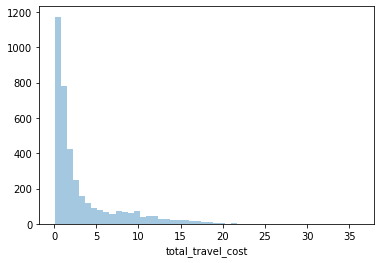

In [100]:
import seaborn as sns
sns.distplot(bike_data[bike_data.mode_id==1]['total_travel_cost'], kde=False)

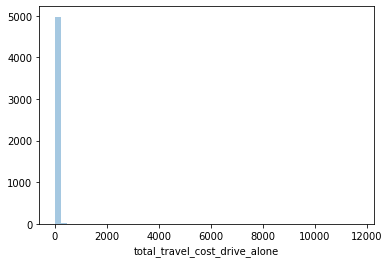

In [102]:
sns.distplot(sim_bike_data['total_travel_cost_drive_alone'], kde=False)

In [103]:
sim_bike_data['total_travel_cost_drive_alone'].max() # we need to figure out how we will put some sort of upper bound here

11702.245221996585